<h1>Soft Actor-Critic (SAC) on Lunar Lander </h1>

# Ziad Al-Ziadi and Behzad Javaheri

### Task 3 Deep Reinforcement Learning

**Objective:** to implement and evaluate the Soft Actor-Critic deep reinforcement learning proposed by Haarnoja et al., (2018) to the Lunar Lander problem. 

**Background:** This newly developed off-policy algorithm is reported to be more sample efficient compared to other reinforcement learning algorithms. For example, Proximal Policy Optimization (PPO), Trust Region Policy Optimization (TRPO) and Asynchronous Actor-Critic Agents (A3C) suffer from sample inefficiency due to on-policy learning approach. This approach requires new samples after each policy update. In contrast, off-policy approaches (e.g. Deep Deterministic Policy Gradient (DDPG)) utilise replay buffer to efficiently learn from past experience and Twin Delayed Deep Deterministic Policy Gradient (TD3PG) are able to learn efficiently from past samples using experience replay buffer. These improved approaches, however, suffer from high sensetivity to hyperparameters and therefore need significant tuning allowing to allow convergance. A recently reported method by Haarnoja et al., (2018) described as Soft-Actor Critic (SAC) improves on off-policy approaches allowing to reduce convergence brittleness.

**Summary:** SAC is primarily defined for robust and stable learning in continous action space environments. It attempts to maximize entropy of a policy in addition to the total reward. This high entropy encourages exploration leading to policy to assign same probabilities to actions with the same or close Q-values. It also helps to prevent repeated selection of a particular action that could exploit some inconsistency in the approximated Q-function.

SAC builds on previous off-policy models but avoids brittleness by high entropy encouraging exploration and not favouring any of the available actions. The following is the overall structure of SAC:

<center>OpenAI Spinning Up: https://spinningup.openai.com/en/latest/algorithms/sac.html</center>


Herein, we construct SAC to apply to the Lunar Lander problem using OpenAI gym environment. The following table of contents represents the implemented steps:
<!--TABLE OF CONTENTS-->
**Table of Contents**

 - **Defining actor, critic and value networks**

 - **Setting up the agent's memory**

 - **Initialising Lunar Lander Continous OpenAI Gym environment. This section will contain information on the size of the action space, hyperparameters of hidden layers**

 - **Training and evaluation**

 - **Animation**

#### Importing required libraries

In [1]:
import random
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, set_matplotlib_formats, display
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import seaborn as sns
from IPython.display import display
%matplotlib inline
import plotly.io as pio
set_matplotlib_formats('retina')
pio.renderers.default='notebook'
mpl.rcParams['figure.dpi'] = 300

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Using CUDA if gpu to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Imports specifically so we can render outputs in Jupyter.
import JSAnimation
#from JSAnimation.IPython_display import display_animation

#### 1. Defining actor, critic and value networks

In [2]:
# Defining actor network (policy network) - finds the optimal policy

class ActorNetwork(nn.Module):
    def __init__(self, n_inputs, n_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(ActorNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.fc1 = nn.Linear(n_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, n_actions) # Mean of the distribution for our policy
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, n_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]
    
# Defining critic network corresponding to a fully connected network with two hidden layers in line with Haarnoja et al., (2018)

class CriticNetwork(nn.Module):
    def __init__(self, n_inputs, n_actions, hidden_size, init_w=3e-3):
        super(CriticNetwork, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs + n_actions, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.q = nn.Linear(hidden_size, 1)

        self.q.weight.data.uniform_(-init_w, init_w)
        self.q.bias.data.uniform_(-init_w, init_w)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.q(x)
        return x

# Defining value network
class ValueNetwork(nn.Module):
    def __init__(self, state_size, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.v.weight.data.uniform_(-init_w, init_w)
        self.v.bias.data.uniform_(-init_w, init_w)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.v(x)
        return x

#### 2. Setting up the agent's memory

In [3]:
# Defining the agent's memory (replay buffer) to store and sample the agent's experience
class ReplayBuffer:
    def __init__(self, max_size):
        self.mem_size = max_size
        self.buffer = []
        self.memory_counter = 0
    
    def store_transition(self, state, action, reward, next_state, terminal):
        if len(self.buffer) < self.mem_size:
            self.buffer.append(None)
        self.buffer[self.memory_counter] = (state, action, reward, next_state, terminal)
        self.memory_counter = (self.memory_counter + 1) % self.mem_size
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, terminal = map(np.stack, zip(*batch))
        return state, action, reward, next_state, terminal
    
    def __len__(self):
        return len(self.buffer)

#### 3.1 Initialising Lunar Lander Continous OpenAI Gym environment. Defining hyperparameters and functions for each element.
#### The parameters are defined according to haarnoja et al., (2018)

<center>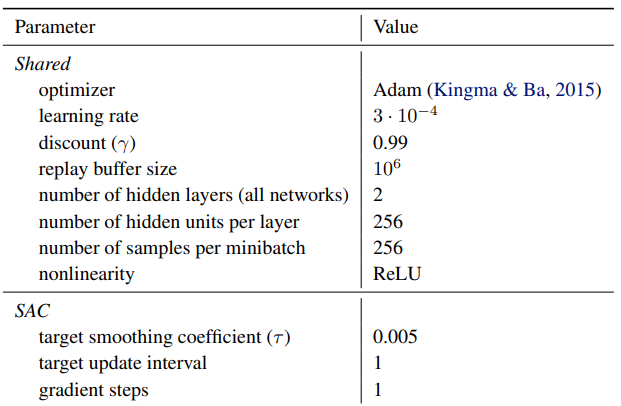</center>

<center>Haarnoja et al., (2018): https://arxiv.org/pdf/1801.01290.pdf</center>

In [4]:
# Training hyperparameters according to the original paper by Haarnoja et al., (2018)

optimizer = optim.Adam         # Optimizer
learning_rate  = 0.05        # Learning rate
discount = 0.33                # Discount factor for reward
replay_buffer_size = 1000000   # Replay buffer size
hidden_size = 256              # Hidden size (default: 256)
tau = 0.5                     # Target smoothing coefficient
max_frames  = 40000
max_steps   = 500
update_interval   = 0
rewards = []
batch_size  = 128

replay_buffer = ReplayBuffer(replay_buffer_size)

# Defining functions for training different elements
def update(batch_size,discount=0.99,tau=1e-2,):
    state, action, reward, next_state, terminal = replay_buffer.sample(batch_size)
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    terminal   = torch.FloatTensor(np.float32(terminal)).unsqueeze(1).to(device)

    predicted_q_value1 = dense_layer_1(state, action)
    predicted_q_value2 = dense_layer_2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = actor_net.evaluate(state)

# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - terminal) * discount * target_value
    q_value_loss1 = q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = q_criterion2(predicted_q_value2, target_q_value.detach())
    q_optimizer1.zero_grad()
    q_value_loss1.backward()
    q_optimizer1.step()
    q_optimizer2.zero_grad()
    q_value_loss2.backward()
    q_optimizer2.step()
    
# Training Value Function
    predicted_new_q_value = torch.min(dense_layer_1(state, new_action),dense_layer_2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    
# Training Policy Function
    actor_loss = (log_prob - predicted_new_q_value).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau)

#### 3.2 Initialising Lunar Lander Continous OpenAI Gym environment

In [5]:
env = gym.make("LunarLanderContinuous-v2")

action_size = env.action_space.shape[0]
state_size  = env.observation_space.shape[0]

actor_net = ActorNetwork(state_size, action_size, hidden_size).to(device)

dense_layer_1 = CriticNetwork(state_size, action_size, hidden_size).to(device)
dense_layer_2 = CriticNetwork(state_size, action_size, hidden_size).to(device)

value_net = ValueNetwork(state_size, hidden_size).to(device)
target_value_net = ValueNetwork(state_size, hidden_size).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    
value_criterion  = nn.MSELoss()
q_criterion1 = nn.MSELoss()
q_criterion2 = nn.MSELoss()

value_optimizer  = optimizer(value_net.parameters(), lr=learning_rate)
q_optimizer1 = optimizer(dense_layer_1.parameters(), lr=learning_rate)
q_optimizer2 = optimizer(dense_layer_2.parameters(), lr=learning_rate)
actor_optimizer = optimizer(actor_net.parameters(), lr=learning_rate)

#### 4. Training and evaluation

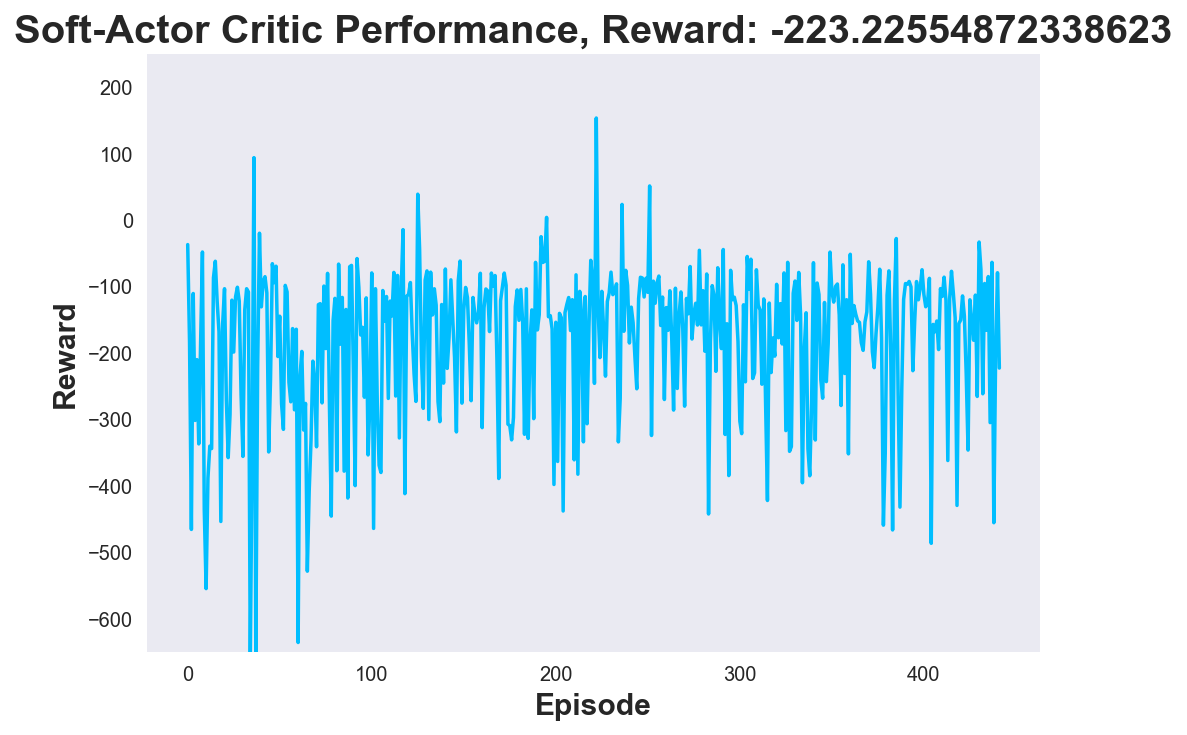

In [6]:
# Defining a plotting function to dynamically plot the reward
plt.style.use("seaborn")

def plot(update_interval, rewards):
    clear_output(True)
    plt.plot(rewards, color='#00BEFF')
    plt.title('Soft-Actor Critic Performance, Reward: %s' % (rewards[-1]), size=20, weight="bold")
    plt.xlabel('Episode', size=15, weight="bold");
    plt.ylabel('Reward', size=15, weight="bold");
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.ylim(-650, 250)
    plt.grid(b=None)
    plt.show()
    plt.style.use("seaborn")

# Performing a training loop

while update_interval < max_frames: # 0 and 40,000
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if update_interval >1000:
            action = actor_net.get_action(state).detach()
            next_state, reward, terminal, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, terminal, _ = env.step(action)
        
        replay_buffer.store_transition(state, action, reward, next_state, terminal)
        if len(replay_buffer) > batch_size:
            update(batch_size)

        state = next_state
        episode_reward += reward
        update_interval += 1
        
#Plotting reward dynamically at present at every 1000 frames.  The maximum is number of steps is set in hyperparameter max_steps, after which the environment will terminate.
        if update_interval % 10000 == 0:
            plot(update_interval,rewards)
        
        if terminal:
            break
        
    rewards.append(episode_reward)


#### 5.Animation ****WARNING**** this animation will NOT work on Jupyter Notebook and will ONLY work on a PyCharm IDE (where it was built)

In [7]:
#Source: https://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
import gym

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(anim)

env = gym.make("LunarLanderContinuous-v2")

# Run a demo of the environment
state = env.reset()
cum_reward = 0
frames = []
for t in range(50000):
    # Render into memory. 
    frames.append(env.render(mode = 'rgb_array'))
    action = ActorNetwork.get_action(state)
    state, reward, terminal, info = env.step(action.detach())
    if terminal:
        break
        
env.close()
display_frames_as_gif(frames)

ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    